In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm

In [195]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/32/10/4689bda37403f7dd029d550c4446e0097c2f33b8ae877b235e76d5c49bc2/xgboost-2.0.0-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.7 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.7 MB 1.2 MB/s eta 0:01:22
   ---------------------------------------- 0.1/99.7 MB 1.2 MB/s eta 0:01:22
   ---------------------------------------- 0.1/99.7 MB 1.2 MB/s eta 0:01:22
   ---------------------------------------- 0.3/99.7 MB 1.0 MB/s eta 0:01:36
   ---------------------------------------- 0.4/99.7 MB 1.3 MB/s eta 0:01:14
   ---------------------------------------- 0.5/99.7 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.5/99.7 MB 1.5 MB/s eta 0:01:06
   ---------------------------------------- 0.

In [196]:
import xgboost as xgb

In [206]:
# Load the data
data = pd.read_csv('direct_data.csv')
data.head(10)

,hour_sin,hour_cos,month_sin,month_cos,day_sin,day_cos,load_lag_1,load_lag_2,load_lag_3,load_lag_4,...,wind_direction_lead_38,wind_direction_lead_39,wind_direction_lead_40,wind_direction_lead_41,wind_direction_lead_42,wind_direction_lead_43,wind_direction_lead_44,wind_direction_lead_45,wind_direction_lead_46,wind_direction_lead_47
0,0.87,-0.50,1.00,0.00,0.94,0.35,"1,005,723.20","981,316.72","976,045.86","978,078.66",...,109.00,215.00,320.00,231.00,142.00,52.00,82.00,113.00,143.00,186.00
1,0.87,-0.50,1.00,0.00,0.99,0.15,"979,472.20","980,170.87","989,417.72","994,106.34",...,184.00,179.00,174.00,179.00,184.00,189.00,180.00,172.00,163.00,206.00
2,0.87,-0.50,1.00,0.00,0.20,0.98,"1,055,779.08","988,560.16","958,369.05","948,634.86",...,178.00,179.00,181.00,183.00,184.00,186.00,160.00,134.00,108.00,149.00
3,0.87,-0.50,1.00,0.00,0.39,0.92,"1,087,711.23","1,024,926.97","1,008,084.09","1,002,856.93",...,212.00,227.00,241.00,191.00,140.00,90.00,78.00,67.00,55.00,132.00
4,0.87,-0.50,1.00,0.00,0.57,0.82,"1,096,427.08","1,036,764.74","1,017,226.10","1,010,926.37",...,190.00,190.00,191.00,169.00,147.00,125.00,126.00,126.00,126.00,164.00
5,0.87,-0.50,1.00,0.00,0.72,0.69,"1,090,908.76","1,026,979.35","1,008,668.09","1,007,275.64",...,184.00,183.00,182.00,175.00,168.00,161.00,171.00,181.00,191.00,215.00
6,0.87,-0.50,1.00,0.00,0.85,0.53,"1,066,443.62","1,036,307.22","1,039,029.13","1,035,614.28",...,215.00,194.00,172.00,177.00,182.00,186.00,230.00,274.00,318.00,312.00
7,0.87,-0.50,0.87,-0.50,0.94,0.35,"1,049,890.44","1,005,692.91","1,011,748.41","1,017,838.77",...,218.00,196.00,173.00,204.00,236.00,267.00,292.00,317.00,342.00,320.00
8,0.87,-0.50,0.87,-0.50,0.99,0.15,"981,910.34","988,984.29","998,663.96","1,005,511.37",...,305.00,316.00,327.00,224.00,121.00,18.00,18.00,19.00,20.00,113.00
9,0.87,-0.50,0.87,-0.50,0.20,0.98,"1,092,136.58","1,018,785.56","999,713.34","995,226.85",...,312.00,319.00,327.00,218.00,109.00,0.00,116.00,231.00,346.00,325.00


In [46]:
lags = ['load_lag_'+str(i+1) for i in range(168)]

In [11]:
len(data)*0.9

1251.9

In [210]:
MAE = {
    'naive_forecast': [0 for i in range(0,51)],
    'seasonal_forecast_daily': [0 for i in range(0,51)],
    'seasonal_forecast_weekly': [0 for i in range(0,51)],
    'seasonal_forecast_yearly': [0 for i in range(0,51)],
    'random_walk_forecast': [0 for i in range(0,51)],
    'linear_regression': [0 for i in range(0,51)]
}

MSE = {
    'naive_forecast': [0 for i in range(0,51)],
    'seasonal_forecast_daily': [0 for i in range(0,51)],
    'seasonal_forecast_weekly': [0 for i in range(0,51)],
    'seasonal_forecast_yearly': [0 for i in range(0,51)],
    'random_walk_forecast': [0 for i in range(0,51)],
    'linear_regression': [0 for i in range(0,51)]
}

RMSE = {
    'naive_forecast': [0 for i in range(0,51)],
    'seasonal_forecast_daily': [0 for i in range(0,51)],
    'seasonal_forecast_weekly': [0 for i in range(0,51)],
    'seasonal_forecast_yearly': [0 for i in range(0,51)],
    'random_walk_forecast': [0 for i in range(0,51)],
    'linear_regression': [0 for i in range(0,51)]
}

In [207]:
exog = ['pressure', 'cloud_cover', 'temperature', 'wind_direction', 'wind_speed']
target = ['load']

Num_models = 48

models = [LinearRegression() for i in range(Num_models)]
#models = [xgb.XGBRegressor() for i in range(Num_models)]

In [211]:
window_size = 365
num_forecasts = int(len(data) - 365 - 1)
step = 1

forecasts = ['naive_forecast', 'seasonal_forecast_daily', 'seasonal_forecast_weekly', 
             'seasonal_forecast_yearly', 'random_walk_forecast', 'linear_regression']

for f in tqdm(range(0, num_forecasts)):
    
    start_window = step*f
    end_window = window_size + step*f
    
    train = data[start_window:end_window]
    test = data[end_window:end_window + 1]
    
    y_hat = [test['load_lead_'+str(i)][end_window] for i in range(48)]
    y_hat = pd.DataFrame(y_hat, columns=['load'])
    
    y_hat['naive_forecast'] = train['load_lag_1'][end_window-1]
    y_hat['seasonal_forecast_daily'] = [train['load_lag_'+str(i%24 + 1)][end_window-1] for i in range(47,-1,-1)]
    y_hat['seasonal_forecast_weekly'] = [train['load_lead_'+str(i)][end_window-7] for i in range(48)]
    y_hat['seasonal_forecast_yearly'] = [train['load_lead_'+str(i)][end_window-365] for i in range(48)]
    drift = (train['load_lag_1'][end_window-1]-train['load_lag_1'][start_window])/(365*24-1)
    y_hat['random_walk_forecast'] = y_hat['naive_forecast']+[i*drift for i in range(1,49)]
    
 ######################################## INSERT FORECAST HERE ########################################   

    predictions = []
    
    for m in range(Num_models):
        
        train_features = train[[exog[i]+'_lead_'+str(m) for i in range(len(exog))] + lags + ['day_sin','day_cos']]
        test_features = test[[exog[i]+'_lead_'+str(m) for i in range(len(exog))] + lags + ['day_sin','day_cos']]
        train_target = train['load_lead_'+str(m)]
        #test_target = test['load_lead_'+str(model)]
        
        
        models[m].fit(train_features, train_target)

        predictions += [models[m].predict(test_features)[0]]
        
    y_hat['linear_regression'] = predictions
    
    ###################################################################################################
    
    
    for forecast in forecasts:
        abs_err = (abs(y_hat[forecast]-y_hat['load']))
        MAE[forecast][0:48] = np.add(MAE[forecast][0:48],abs_err/num_forecasts)
        MSE[forecast][0:48] = np.add(MSE[forecast][0:48],(abs_err**2)/num_forecasts)
        

100%|██████████████████████████████████████████████████████████████████████████████| 1025/1025 [20:56<00:00,  1.23s/it]


In [212]:
for forecast in forecasts:
    
    MAE[forecast][48] = np.mean(MAE[forecast][0:24])
    MAE[forecast][49] = np.mean(MAE[forecast][24:48])
    MAE[forecast][50] = np.mean(MAE[forecast][0:48])
    
    MSE[forecast][48] = np.mean(MSE[forecast][0:24])
    MSE[forecast][49] = np.mean(MSE[forecast][24:48])
    MSE[forecast][50] = np.mean(MSE[forecast][0:48])
    
    RMSE[forecast][0:48] = np.sqrt(MSE[forecast][0:48])
    RMSE[forecast][48] = np.mean(RMSE[forecast][0:24])
    RMSE[forecast][49] = np.mean(RMSE[forecast][24:48])
    RMSE[forecast][50] = np.mean(RMSE[forecast][0:48])

MAE_df = pd.DataFrame(MAE, index=['H'+str(i) for i in range(1,49)] + ['First 24 hours'] + ['Second 24 hours'] + ['Total'])
MSE_df = pd.DataFrame(MSE, index=['H'+str(i) for i in range(1,49)] + ['First 24 hours'] + ['Second 24 hours'] + ['Total'])
RMSE_df = pd.DataFrame(RMSE, index=['H'+str(i) for i in range(1,49)] + ['First 24 hours'] + ['Second 24 hours'] + ['Total'])

In [138]:
pd.options.display.float_format = '{:20,.2f}'.format

In [213]:
y_hat.head()

,load,naive_forecast,seasonal_forecast_daily,seasonal_forecast_weekly,seasonal_forecast_yearly,random_walk_forecast,linear_regression
0,"1,004,102.43","1,032,445.43","1,012,115.43","1,125,467.93","1,208,285.05","1,032,436.49","1,012,100.88"
1,"1,017,978.43","1,032,445.43","1,037,922.43","1,196,084.93","1,294,285.05","1,032,427.54","1,055,987.82"
2,"1,026,308.93","1,032,445.43","1,064,079.43","1,244,780.93","1,346,785.05","1,032,418.60","1,083,667.15"
3,"1,038,560.43","1,032,445.43","1,080,924.93","1,263,056.93","1,353,285.05","1,032,409.66","1,093,352.86"
4,"1,038,102.93","1,032,445.43","1,083,525.43","1,257,817.93","1,340,285.05","1,032,400.71","1,088,692.31"


In [190]:
MAE_df

,naive_forecast,seasonal_forecast_daily,seasonal_forecast_weekly,seasonal_forecast_yearly,random_walk_forecast,linear_regression
H1,"93,288.94","85,590.38","36,260.41","110,712.52","93,290.85","8,046.09"
H2,"158,741.19","110,862.31","42,793.84","138,944.94","158,745.43","14,733.99"
H3,"201,791.77","121,227.09","46,575.15","152,466.65","201,797.69","19,227.99"
H4,"215,787.60","121,561.63","47,488.97","153,440.19","215,795.52","20,965.68"
H5,"214,601.12","120,052.99","47,958.40","151,531.62","214,610.92","20,729.16"
H6,"206,395.25","118,738.78","48,100.48","148,870.84","206,406.90","20,674.36"
H7,"212,049.18","122,850.87","49,994.99","153,873.30","212,062.54","22,161.41"
H8,"208,202.96","123,359.76","50,663.65","154,515.44","208,217.84","23,602.64"
H9,"197,505.96","120,496.45","49,780.52","151,749.49","197,522.29","23,377.51"
H10,"174,275.39","108,825.35","46,339.18","142,624.29","174,293.83","22,524.61"


In [214]:
frames = [MAE_df.iloc[48:51], MSE_df.iloc[48:51], RMSE_df.iloc[48:51]]
pd.concat(frames, keys=["MAE", "MSE", "RMSE"])

naive_forecast  seasonal_forecast_daily  \
MAE  First 24 hours            118,845.92                69,480.21   
     Second 24 hours           124,074.05                71,081.57   
     Total                     121,459.98                70,280.89   
MSE  First 24 hours     25,189,941,048.90        12,023,535,358.69   
     Second 24 hours    27,248,890,960.25        12,220,572,648.66   
     Total              26,219,416,004.57        12,122,054,003.67   
RMSE First 24 hours            139,581.58                93,651.73   
     Second 24 hours           146,135.56                95,425.46   
     Total                     142,858.57                94,538.60   

                      seasonal_forecast_weekly  seasonal_forecast_yearly  \
MAE  First 24 hours                  36,571.22                100,720.27   
     Second 24 hours                 36,552.51                100,769.85   
     Total                           36,561.86                100,745.06   
MSE  First 24 hours           3,159,911,744.61         19,588,383,941.99   
     Second 24 hours          3,159,061,384.62         19,595,296,320.14   
     Total                    3,159,486,564.62         19,591,840,131.06   
RMSE First 24 hours                  53,295.27                128,828.81   
     Second 24 hours                 53,287.27                128,851.89   
     Total                           53,291.27                128,840.35   

                      random_walk_forecast    linear_regression  
MAE  First 24 hours             118,858.35            19,399.72  
     Second 24 hours            124,122.91            43,690.35  
     Total                      121,490.63            31,545.03  
MSE  First 24 hours      25,192,332,965.85       705,570,669.79  
     Second 24 hours     27,255,627,229.29     4,182,996,904.81  
     Total               26,223,980,097.57     2,444,283,787.30  
RMSE First 24 hours             139,596.33            26,079.49  
     Second 24 hours            146,171.26            59,591.59  
     Total                      142,883.79            42,835.54

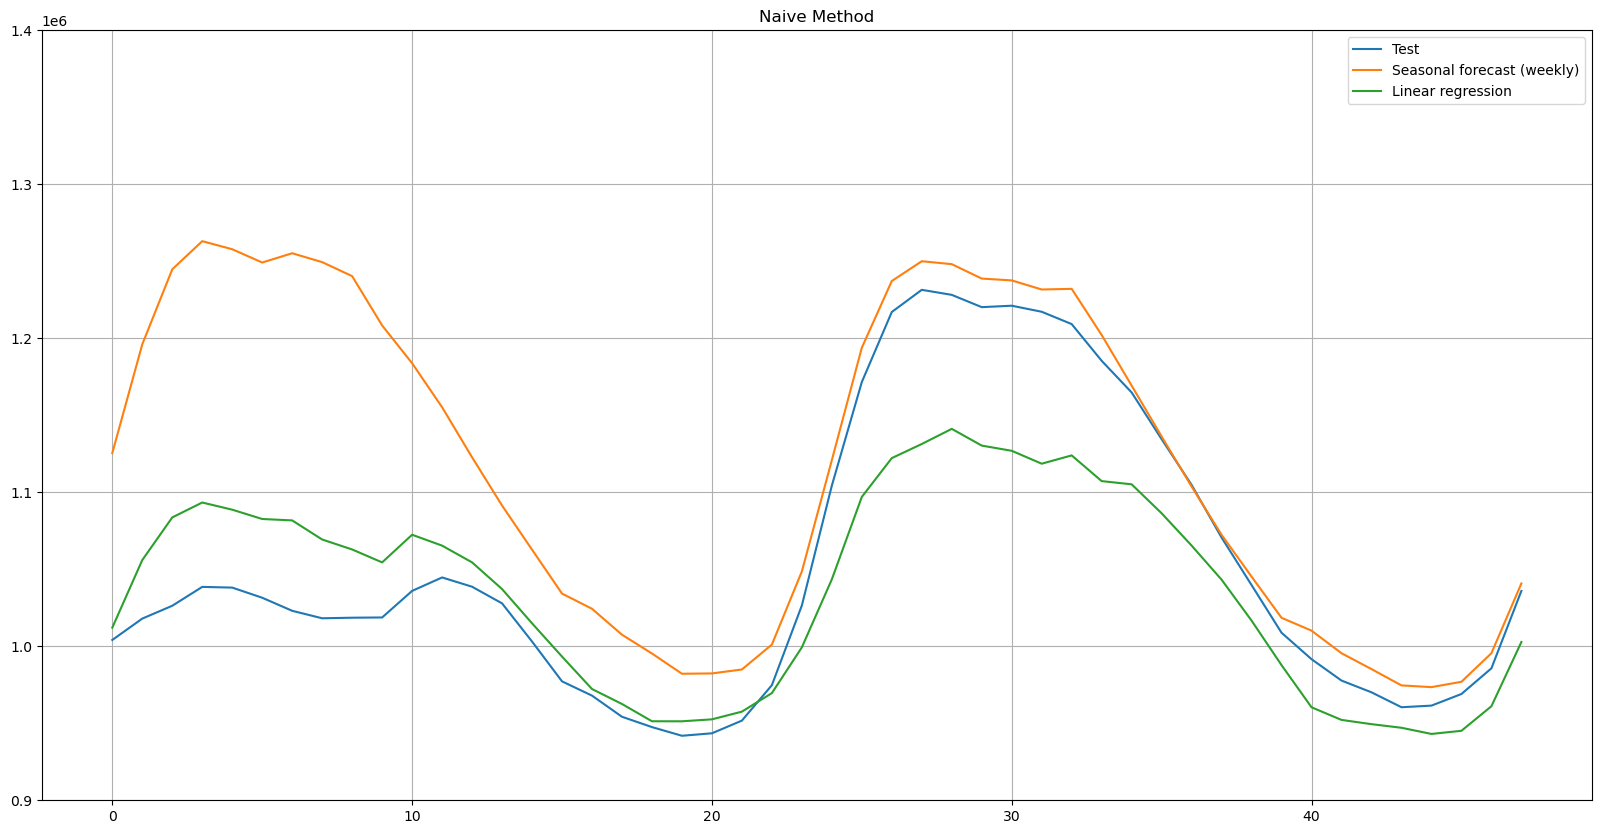

In [215]:
plt.figure(figsize=(20,10))
plt.grid()
#plt.plot(train['load'], label='Train')
plt.plot(y_hat['load'], label='Test')
#plt.plot(y_hat['naive_forecast'], label='Naive forecast')
#plt.plot(y_hat['seasonal_forecast_daily'], label='Seasonal forecast (daily)')
plt.plot(y_hat['seasonal_forecast_weekly'], label='Seasonal forecast (weekly)')
#plt.plot(y_hat['seasonal_forecast_yearly'], label='Seasonal forecast (yearly)')
#plt.plot(y_hat['random_walk_forecast'], label='Random walk with drift forecast')
plt.plot(y_hat['linear_regression'], label='Linear regression')
plt.legend(loc='best')
plt.title('Naive Method')
#plt.xlim(len(data)-2*24,len(data))
plt.ylim(900000,1400000)
plt.show()